In [1]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#CC79A7','#D55E00']


### Import

In [2]:
import glob
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random

In [3]:
os.getcwd()
PATH=os.getcwd()+'/data/out'

In [5]:
def read_data_from_folder(folder_path):
    dfs = pd.DataFrame()
    file_count = 0  # counter for loaded files
    folder_path_add='\\singles'
    folder_path = folder_path + folder_path_add
    # Regex to extract the number after "participant_" and before ".csv"
    # This regex looks for "participant_" followed by one or more digits (\d+)
    # and captures these digits. It expects ".csv" at the end.
    participant_id_regex = re.compile(r'(?:model|participant)_(\d+)\.csv')


    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            # Extract model_id from filename using regex
            match = participant_id_regex.search(filename)
            if match:
                model_id = int(match.group(1)) # Convert the captured digits to an integer
                df['model_id'] = model_id # Add the model_id column
            else:
                # Handle cases where the filename doesn't match the expected format
                print(f"Warning: Could not extract model_id from filename: {filename}")
                df['model_id'] = None # Or some other indicator of missing ID

            dfs = pd.concat([dfs, df], ignore_index=True)
            file_count += 1  # increment counter

    print(f"{file_count} CSV file(s) loaded.")
    return dfs

In [6]:
import os

def load_models(base_path="predictive"):
    """
    Load one CSV per model folder and create separate DataFrame variables
    named <model_name>_df in the global namespace.

    Parameters
    ----------
    base_path : str
        Path to the directory containing model subdirectories.
    """
    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)

        # Skip the predictive folder itself
        if model_name == "predictive":
            continue

        if os.path.isdir(model_path):
            print(f"Loading model: {model_name} from {model_path}")
            
            df = read_data_from_folder(model_path)
            model_name = model_name.replace("-", "_")  # Replace hyphens with underscores
            globals()[f"{model_name}_df"] = df
            print(f"Loaded {model_name}_df with shape {df.shape}")


In [7]:
load_models(base_path=PATH)

Loading model: centaur-70B from c:\Users\snamazova\OneDrive - dfki.de\Dokumente\study\centaur_eval_simulator\reverse_learning\partial_feedback/data/out\centaur-70B
32 CSV file(s) loaded.
Loaded centaur_70B_df with shape (3200, 6)
Loading model: centaur-70B_last-trial from c:\Users\snamazova\OneDrive - dfki.de\Dokumente\study\centaur_eval_simulator\reverse_learning\partial_feedback/data/out\centaur-70B_last-trial
32 CSV file(s) loaded.
Loaded centaur_70B_last_trial_df with shape (3200, 6)
Loading model: centaur-70B_no_reward_no_rewards from c:\Users\snamazova\OneDrive - dfki.de\Dokumente\study\centaur_eval_simulator\reverse_learning\partial_feedback/data/out\centaur-70B_no_reward_no_rewards
32 CSV file(s) loaded.
Loaded centaur_70B_no_reward_no_rewards_df with shape (3200, 6)
Loading model: centaur-70B_without_task_prompt from c:\Users\snamazova\OneDrive - dfki.de\Dokumente\study\centaur_eval_simulator\reverse_learning\partial_feedback/data/out\centaur-70B_without_task_prompt
32 CSV fil

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'c:\\Users\\snamazova\\OneDrive - dfki.de\\Dokumente\\study\\centaur_eval_simulator\\reverse_learning\\partial_feedback/data/out\\repetetive\\singles'

In [8]:
def bandit_1_prop(df,choice):
  df_copy=df.copy()
  df_copy['bandit1_chosen'] = (df_copy['choice'] == choice).astype(int)
  df_copy['bandit_1_avg']=df_copy.groupby("model_id")["bandit1_chosen"].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
  return df_copy

In [9]:
def plot_bandit_1_avg(df, trial_col="trial_num", bandit_avg_col="bandit_1_avg",label=None):
    """
    Plots the average choice rate of bandit 1 over trials with standard error shading.

    Parameters:
    - df: DataFrame containing trial data.
    - trial_col: Column name representing trial numbers (default: "trial").
    - bandit_avg_col: Column name representing average bandit 1 choice rate (default: "bandit_1_avg").
    """

    # Group by trial and calculate mean and standard error
    grouped = df.groupby(trial_col)[bandit_avg_col]
    mean_bandit_1_avg = grouped.mean()
    std_error = grouped.std() / np.sqrt(grouped.count())  # SE = std / sqrt(N)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_bandit_1_avg.index, mean_bandit_1_avg.values, label='Mean bandit_1_avg', color='blue')

    # Add shaded area for standard error
    plt.fill_between(
        mean_bandit_1_avg.index,
        mean_bandit_1_avg - std_error,
        mean_bandit_1_avg + std_error,
        color='blue',
        alpha=0.3,  # Transparency for standard error region
        label='Standard Error'
    )

    # Add a reference line for chance level (0.5)
    plt.axhline(y=0.5, color="r", linestyle="--", label="Chance Level (0.5)")

    # Labels and title
    plt.xlabel('Trial')
    plt.ylabel('Average bandit_1_avg')
    plt.title('Average bandit_1_avg over Trials with Standard Error')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


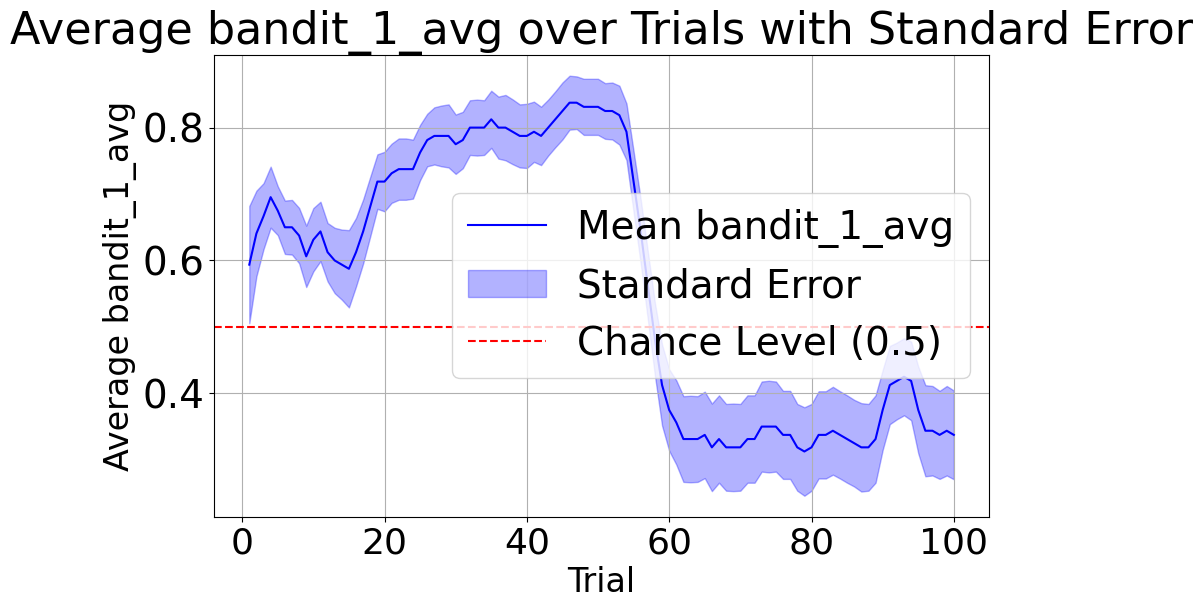

In [10]:
centaur_70B_df=bandit_1_prop(centaur_70B_df,choice='U')
plot_bandit_1_avg(centaur_70B_df,trial_col="trial_num", bandit_avg_col="bandit_1_avg", label='Bandit 1 Average')

### timeline

In [11]:
random.seed(42)

# Number of trials
num_trials = 100

# Define the timeline
timeline = []
for i in range(num_trials):
    while True:
        if i < (num_trials / 2):
            bandit_1_reward = random.choices([1, 0], weights=[0.8, 0.2])[0]
            bandit_2_reward = random.choices([1, 0], weights=[0.2, 0.8])[0]
        else:
            bandit_1_reward = random.choices([1, 0], weights=[0.2, 0.8])[0]
            bandit_2_reward = random.choices([1, 0], weights=[0.8, 0.2])[0]

        if not (bandit_1_reward == 0 and bandit_2_reward == 0):
            break

    timeline.append({
        "bandit_1": {"color": "orange", "value": bandit_1_reward},
        "bandit_2": {"color": "blue", "value": bandit_2_reward}
    })

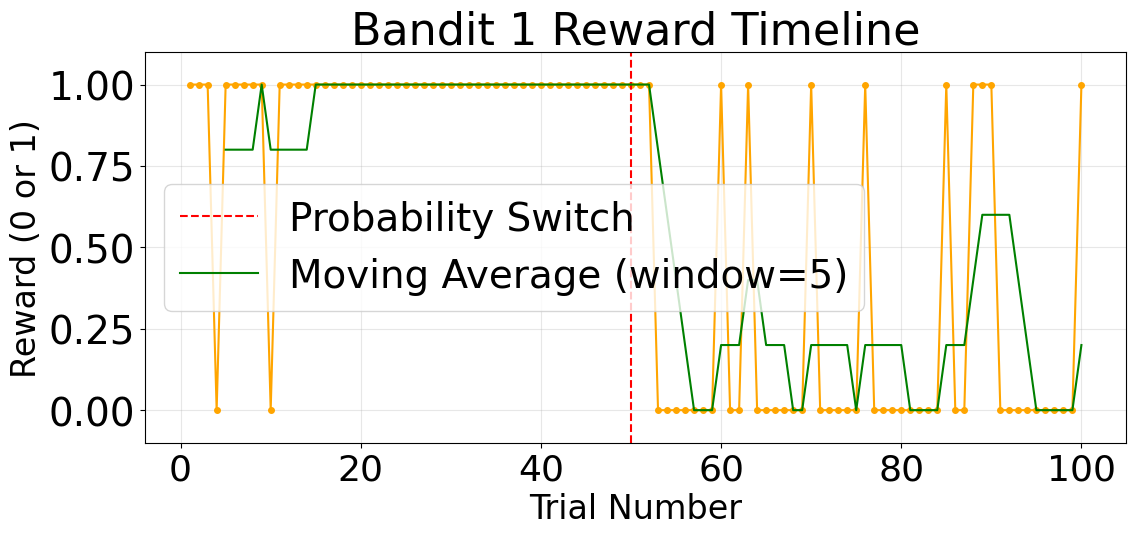

In [12]:
# Extract bandit 1 rewards
bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_trials + 1), bandit_1_rewards, color='orange', marker='o', linestyle='-', markersize=4)

# Add a vertical line at the probability switch point
plt.axvline(x=num_trials/2, color='red', linestyle='--', label='Probability Switch')

# Calculate and plot the moving average (window size = 10)
window_size = 5
moving_avg = np.convolve(bandit_1_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size, num_trials + 1), moving_avg, color='green', linestyle='-', label='Moving Average (window=5)')

# Customize the plot
plt.title('Bandit 1 Reward Timeline')
plt.xlabel('Trial Number')
plt.ylabel('Reward (0 or 1)')
plt.ylim(-0.1, 1.1)  # Set y-axis limits
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Bandit Choice Trends Function

In [13]:
def plot_bandit_choice_trends(human_df=None,df_rep=None, dfs=None, labels=None, colors=None, trial_col="trial_num",
                               bandit_avg_col="bandit_1_avg", reversal_trials=[14, 50],
                              timeline=None,legend_anchor=(0.5, 0.5),
                               xlim=(0, 100), title="Generative performance",
                               margins=True):
    """
    Plots bandit 1 choice trends with multiple reversal points and overlays model predictions.

    Args:
        human_df (pd.DataFrame): Human data with trial-wise bandit choice.
        dfs (list of pd.DataFrame): Model prediction DataFrames.
        labels (list of str): Labels for models.
        colors (list of str): Colors for plotting (first is for human).
        trial_col (str): Trial number column.
        bandit_avg_col (str): Column for P(choose bandit 1).
        reversal_trials (list of int): List of reversal trial indices.
        xlim (tuple): Trial range to plot.
        title (str): Title for the plot.
        margins (bool): Whether to plot confidence intervals.
    """
    fig, (ax_prob, ax_main) = plt.subplots(
        2, 1, figsize=(12, 10),
        gridspec_kw={'height_ratios': [1, 4]},
        sharex=True
    )

    # --- Reward Probability Transition Plot ---
    for reversal in reversal_trials:
        # Purple bandit
        ax_prob.plot([1, reversal - 2], [0.8, 0.8], 'purple', linewidth=3)
        ax_prob.plot([reversal + 2, xlim[1]], [0.2, 0.2], 'purple', linewidth=3)
        ax_prob.plot([reversal - 2, reversal + 2], [0.8, 0.2], 'purple', linewidth=3)

        # Blue bandit
        ax_prob.plot([1, reversal - 2], [0.2, 0.2], 'blue', linewidth=3)
        ax_prob.plot([reversal + 2, xlim[1]], [0.8, 0.8], 'blue', linewidth=3)
        ax_prob.plot([reversal - 2, reversal + 2], [0.2, 0.8], 'blue', linewidth=3)

    #ax_prob.set_ylabel('Reward Probability\n (Bandit 1)')
    ax_prob.set_ylim(0, 1)
    ax_prob.set_xlim(xlim)
    ax_prob.set_yticks([0.2, 0.8])
    ax_prob.set_yticklabels(['20%', '80%'])
    ax_prob.spines['top'].set_visible(False)
    ax_prob.spines['right'].set_visible(False)
    ax_prob.set_title("Reward Probability Transition")

    # --- Human data ---
    if human_df is not None:
      grouped = human_df.groupby(trial_col)[bandit_avg_col]
      mean_human = grouped.mean()
      std_human = grouped.std() / np.sqrt(grouped.count())
      human_color = colors[0]

      ax_main.plot(mean_human.index, mean_human.values, color=human_color,
                  linewidth=0.5, label='Human', alpha=1, zorder=1)
      if margins:
          ax_main.fill_between(mean_human.index, mean_human - std_human,
                              mean_human + std_human, color=human_color,
                              alpha=0.2, zorder=1)
    if df_rep is not None:
      grouped = df_rep.groupby(trial_col)[bandit_avg_col]
      mean_human = grouped.mean()
      std_human = grouped.std() / np.sqrt(grouped.count())
      human_color = colors[-1]

      ax_main.plot(mean_human.index, mean_human.values, color=human_color,
                  linewidth=1.5, label=labels[-1], alpha=1, zorder=1)
      if margins:
          ax_main.fill_between(mean_human.index, mean_human - std_human,
                              mean_human + std_human, color=human_color,
                              alpha=0.3, zorder=1)


    # --- Model Data ---
    if dfs is not None and labels is not None and colors is not None: # Add None check
        # Use colors from index 1 onwards for models, assuming colors[0] is for human
        model_colors = colors[1:]
        for i, (df, label) in enumerate(zip(dfs, labels)):
            grouped = df.groupby(trial_col)[bandit_avg_col]
            mean_model = grouped.mean()
            sem_model = grouped.std() / np.sqrt(grouped.count())

            # Ensure color index is within bounds of model_colors
            model_color = model_colors[i % len(model_colors)] if model_colors else None


            ax_main.plot(mean_model.index, mean_model.values, label=label,
                         color=model_color, linestyle='-', linewidth=1.5, alpha=1, zorder=3)
            if margins:
                ax_main.fill_between(mean_model.index, mean_model - sem_model,
                                     mean_model + sem_model, color=model_color,
                                     alpha=0.4, zorder=3)

    # --- Reversal Lines ---
    for reversal in reversal_trials:
        ax_main.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0,
                        alpha=0.3, zorder=0, label=f'Reversal (Trial {reversal})')
    #--- Reward Ground Truth
    if timeline is not None: # Add None check
        # Need to determine the length of the timeline for x-axis
        num_trials_timeline = len(timeline) if timeline else 0
        if num_trials_timeline > 0:
            bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
            ax_main.plot(range(1, num_trials_timeline + 1), bandit_1_rewards, color='gray', marker='|',
                        linestyle='', markersize=10, alpha=0.6, label='Ground Truth Rewards')


    ax_main.set_xlabel("Trial Number")
    ax_main.set_ylabel("Bandit 1 Choice Rate")
    #ax_main.set_title(f"{title}")
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(-0.05, 1.05)
    #ax_main.legend()
    ax_main.grid(False)
    # Save handles and labels for external legend
    handles, labels_legend = ax_main.get_legend_handles_labels()
    legend_fig = plt.figure(figsize=(6, 2))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis("off")
    legend = legend_ax.legend(handles, labels_legend, loc='center', frameon=False)
    ax_main.margins(x=0.04)

    plt.tight_layout()
    # plt.show() # Remove plt.show() here
    return fig, legend_fig

In [14]:
def plot_bandit_choice_trends_single_axis(human_df=None, df_rep=None, dfs=None, labels=None, colors=None,
                                          trial_col="trial_num", bandit_avg_col="bandit_1_avg",
                                          reversal_trials=[14, 50], timeline=None,
                                          xlim=(0, 100), margins=True, legend_anchor=(0.5, 0.5),
                                          fig_size=(14, 9)):
    """
    Plots bandit 1 choice trends (no reward probability subplot). Overlays human and model predictions.

    Args:
        human_df (pd.DataFrame): Human data with trial-wise bandit choice.
        df_rep (pd.DataFrame): Repetitive baseline model.
        dfs (list of pd.DataFrame): Model prediction DataFrames.
        labels (list of str): Labels for models.
        colors (list of str): Colors for plotting (first is for human).
        trial_col (str): Trial number column.
        bandit_avg_col (str): Column for P(choose bandit 1).
        reversal_trials (list of int): List of reversal trial indices.
        timeline (list of dict): Optional reward schedule for reference markers.
        xlim (tuple): Trial range to plot.
        margins (bool): Whether to plot confidence intervals.
        legend_anchor (tuple): Anchor position for external legend.
    """
    fig, ax = plt.subplots(figsize=fig_size)

    # --- Human Data ---
    if human_df is not None:
        grouped = human_df.groupby(trial_col)[bandit_avg_col]
        mean = grouped.mean()
        sem = grouped.std() / np.sqrt(grouped.count())
        human_color = colors[0]

        ax.plot(mean.index, mean.values, color=human_color, linewidth=0.5, label='Human', alpha=1)
        if margins:
            ax.fill_between(mean.index, mean - sem, mean + sem, color=human_color, alpha=0.2)

    # --- Repetitive Baseline ---
    if df_rep is not None:
        grouped = df_rep.groupby(trial_col)[bandit_avg_col]
        mean = grouped.mean()
        sem = grouped.std() / np.sqrt(grouped.count())
        rep_color = colors[-1]

        ax.plot(mean.index, mean.values, color=rep_color, linewidth=1.5, label=labels[-1], alpha=1)
        if margins:
            ax.fill_between(mean.index, mean - sem, mean + sem, color=rep_color, alpha=0.3, hatch='/')

    # --- Model Data ---
    if dfs is not None and labels is not None and colors is not None:
        model_colors = colors[1:]  # skip human
        for i, (df, label) in enumerate(zip(dfs, labels)):
            grouped = df.groupby(trial_col)[bandit_avg_col]
            mean = grouped.mean()
            sem = grouped.std() / np.sqrt(grouped.count())
            model_color = model_colors[i % len(model_colors)]

            ax.plot(mean.index, mean.values, label=label, color=model_color, linewidth=1.5, alpha=1)
            if margins:
                ax.fill_between(mean.index, mean - sem, mean + sem, color=model_color, alpha=0.4)

    # --- Reversal Markers ---
    for reversal in reversal_trials:
        ax.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0, alpha=0.3)

    # --- Optional Ground Truth Rewards ---
    if timeline is not None:
        bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
        ax.plot(range(1, len(bandit_1_rewards)+1), bandit_1_rewards,
                color='gray', marker='|', linestyle='', markersize=10, alpha=0.6,
                label='Ground Truth Rewards')
    pad_value = fig_size[1] * 3  # multiplier can be adjusted

    # --- Formatting ---
    ax.set_xlabel("Trial Number",labelpad=pad_value)
    ax.set_ylabel("Bandit 1 Choice Rate",labelpad=20)
    ax.set_xlim(xlim)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    ax.margins(x=0.04)

    # --- Legend saved separately ---
    handles, labels_legend = ax.get_legend_handles_labels()
    legend_fig = plt.figure(figsize=(6, 2))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis("off")
    legend_ax.legend(handles, labels_legend, loc='center', frameon=False)
    ax.margins(x=0.04)
    plt.tight_layout()
    return fig, legend_fig


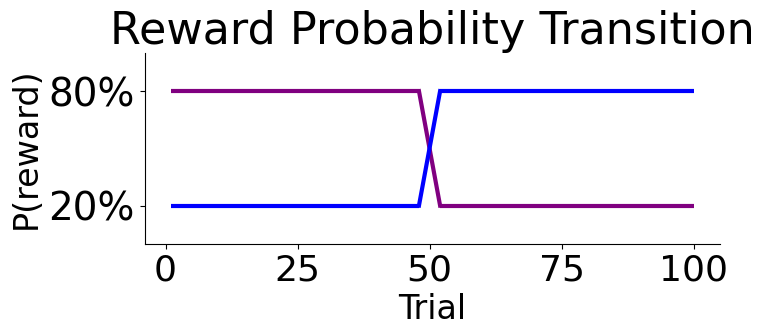

In [15]:
# Define where the reward probabilities reverse
reversal_trial = 50

# Create a figure and axis
fig, ax_prob = plt.subplots(figsize=(8, 4))

# --- Probability Transition Plot ---
# First option (e.g., orange)
ax_prob.plot([1, reversal_trial-2], [0.8, 0.8], 'purple', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial+2, 100], [0.2, 0.2], 'purple', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial-2, reversal_trial+2], [0.8, 0.2], 'purple', linewidth=3)

# Second option (e.g., blue)
ax_prob.plot([1, reversal_trial-2], [0.2, 0.2], 'blue', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial+2, 100], [0.8, 0.8], 'blue', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial-2, reversal_trial+2], [0.2, 0.8], 'blue', linewidth=3)

# Formatting
ax_prob.set_ylabel('P(reward)')
ax_prob.set_ylim(0, 1)
ax_prob.set_yticks([0.2, 0.8])
ax_prob.set_yticklabels(['20%', '80%'])
ax_prob.spines['top'].set_visible(False)
ax_prob.spines['right'].set_visible(False)

plt.xlabel('Trial')
plt.title('Reward Probability Transition')
plt.tight_layout()
plt.show()


In [16]:
centaur_70B_no_reward_no_rewards_df=bandit_1_prop(centaur_70B_no_reward_no_rewards_df,choice='U')

In [17]:
llama_70B_df=bandit_1_prop(llama_70B_df,choice='U')
llama_70b_partial_df=bandit_1_prop(llama_70b_partial_df,choice='U')

In [18]:
centaur_70B_df=bandit_1_prop(centaur_70B_df,choice='U')

In [19]:
colors_grouped= ['#44403B','#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7','#009E73']


In [20]:
rw_df=pd.read_csv('data/out/rw_only_alpha_gen.csv')

In [21]:
rw_df.rename(columns={'trial':'trial_num'}, inplace=True)

In [22]:
rw_df=bandit_1_prop(rw_df,choice=0)

In [23]:
def set_dynamic_fontsize(fig_width=12, base_font=20):
    scale = fig_width / 6  # 6 is your baseline width, adjust as needed
    plt.rcParams.update({
        'font.size': base_font * scale * 0.65,
        'axes.titlesize': base_font * scale * 1.2,
        'axes.labelsize': base_font * scale * 0.9,
        'xtick.labelsize': base_font * scale * 0.9,
        'ytick.labelsize': base_font * scale * 0.9,
        'legend.fontsize': base_font * scale,
    })

# Example: for a large figure
set_dynamic_fontsize(fig_width=15)

In [24]:
colors_centaur_rw = ['black', '#E69F00', '#D55E00', "#F783C3"]

In [25]:
set_dynamic_fontsize(fig_width=16)

In [26]:
colors_grouped=colors = ['black','#D55E00','#E69F00', '#0072B2','#56B4E9',  "#F783C3"]

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23712\169622152.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Figure size 1600x1100 with 1 Axes>, <Figure size 600x200 with 1 Axes>)

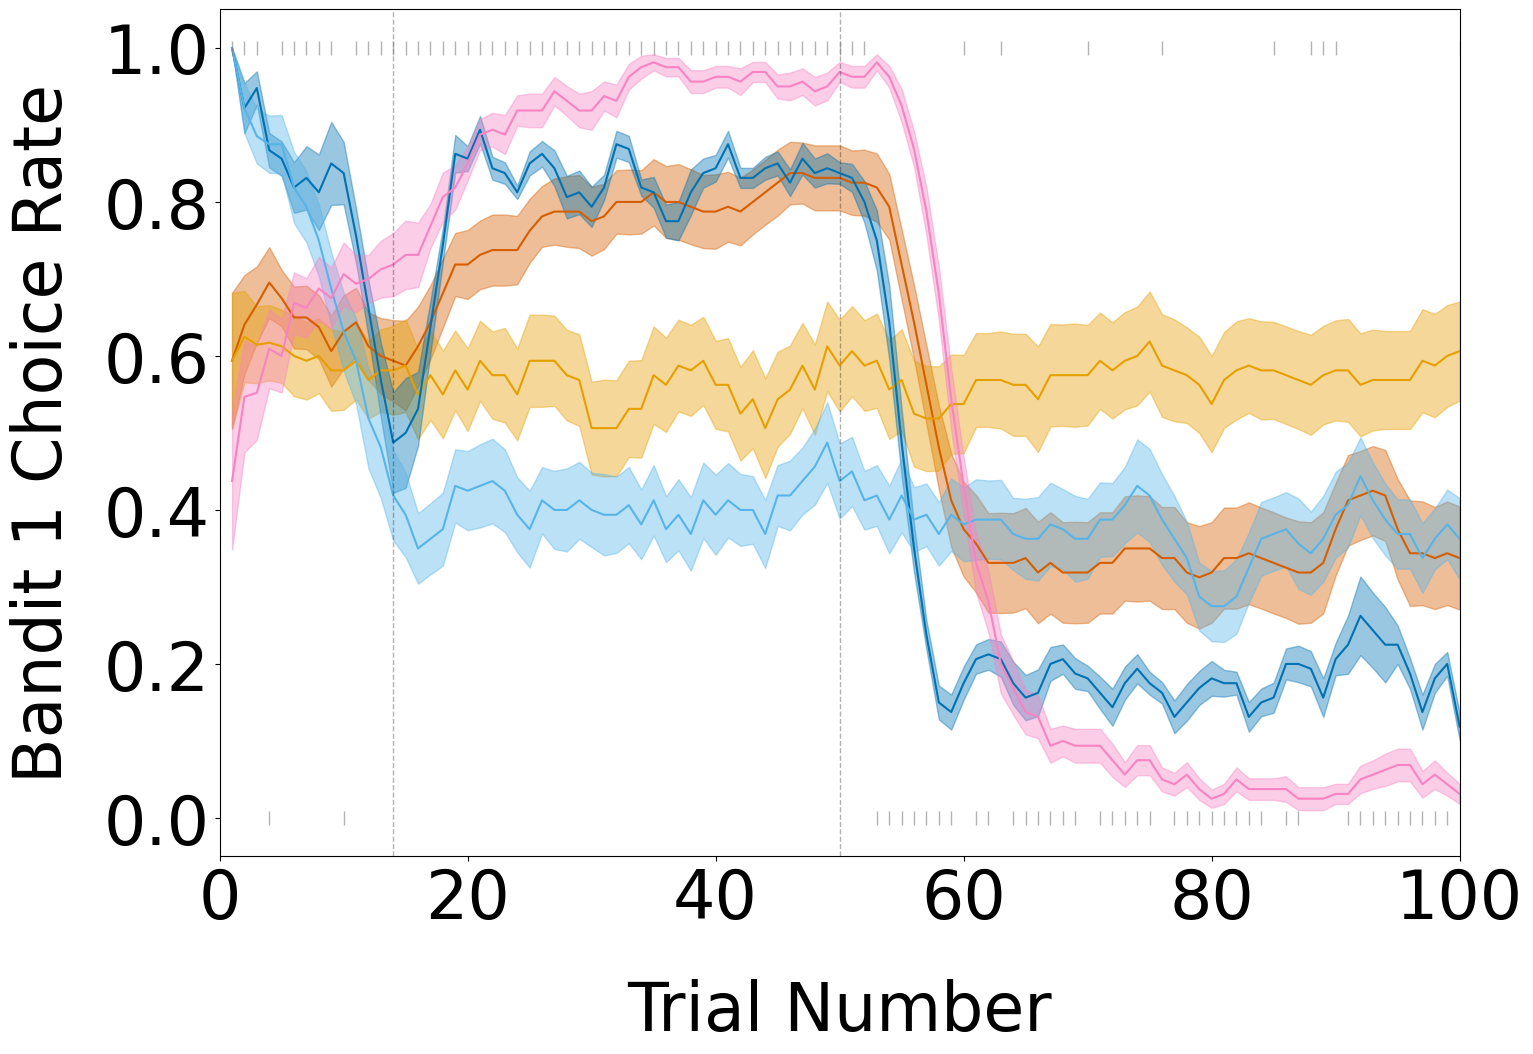

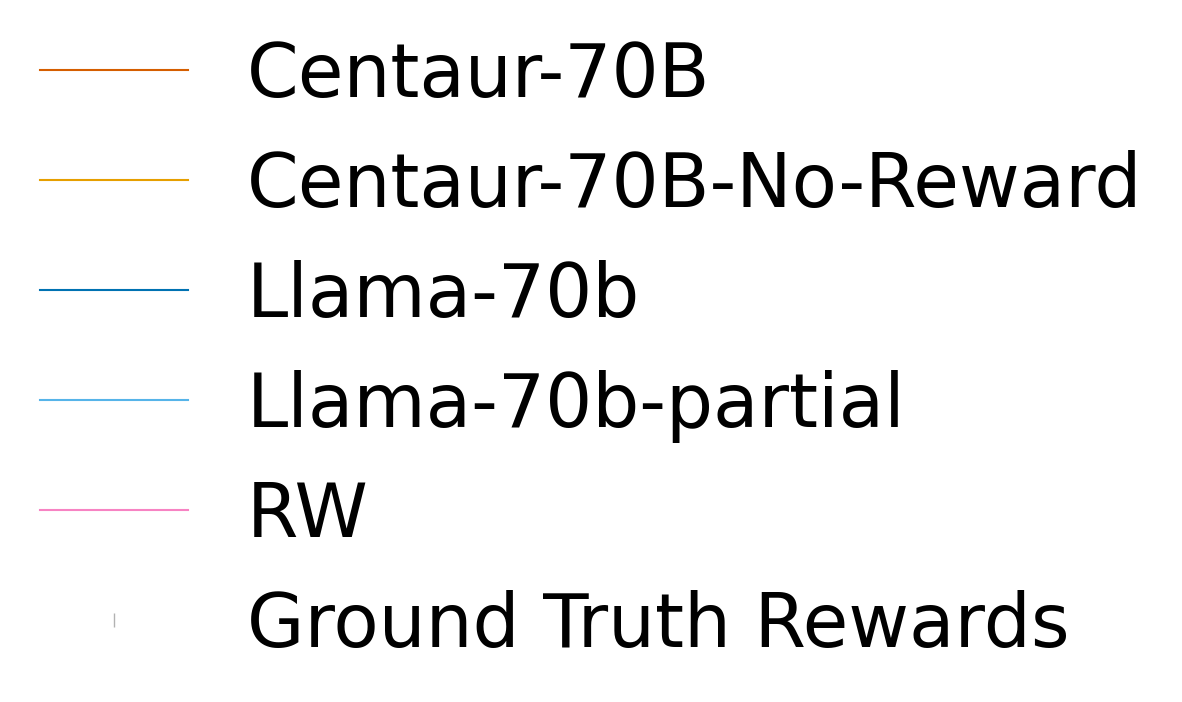

In [27]:
plot_bandit_choice_trends_single_axis(
    human_df=None, 
    df_rep=None,
    dfs=[centaur_70B_df,centaur_70B_no_reward_no_rewards_df,llama_70B_df,llama_70b_partial_df,rw_df],
    labels=['Centaur-70B','Centaur-70B-No-Reward','Llama-70b','Llama-70b-partial','RW'],
    colors=colors_grouped,
    timeline=timeline,
    fig_size=(16,11)
)

In [28]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors_centaur = ['black','#d65db1', '#845ec2', '#F3AEB8', '#EE7E8D','#CAC8E0']

In [29]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors_grouped= ['#44403B','#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7','#009E73']


### score vs trial

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_score_vs_trial(df, trial_col='trial_num', model_id_col='model_id', score_col='cumulative_reward',
                        figsize=(10, 6), title=None):
    """
    Plots average score vs trial across models with standard error margins.

    Parameters:
    df (pd.DataFrame): Input dataframe containing trial, model, and score data
    trial_col (str): Name of column containing trial numbers
    model_id_col (str): Name of column containing model identifiers
    score_col (str): Name of column containing scores
    figsize (tuple): Figure dimensions
    title (str): Custom plot title (optional)
    """
    # Group data and calculate statistics
    df_grouped = df.groupby([trial_col, model_id_col])[score_col].agg(['mean', 'sem']).reset_index()

    # Create plot
    plt.figure(figsize=figsize)

    # Plot each model's line with error bands
    for model_id in df_grouped[model_id_col].unique():
        model_data = df_grouped[df_grouped[model_id_col] == model_id]
        plt.plot(model_data[trial_col], model_data['mean'], label=model_id)
        plt.fill_between(model_data[trial_col],
                         model_data['mean'] - model_data['sem'],
                         model_data['mean'] + model_data['sem'],
                         alpha=0.2)

    # Add labels and legend
    default_title = f"{score_col} vs {trial_col} by {model_id_col} (Mean ± SEM)"
    plt.xlabel(trial_col)
    plt.ylabel(f'Average {score_col}')
    plt.title(title if title else default_title)
    plt.legend(title=model_id_col)
    plt.show()

# Example usage:


### Main Plot

In [34]:
rw_df.rename(columns={'trial': 'trial_num'}, inplace=True)

In [36]:
colors_large_models_only= ['black','#D55E00', '#0072B2', '#CC79A7','#009E73']

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23712\169622152.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


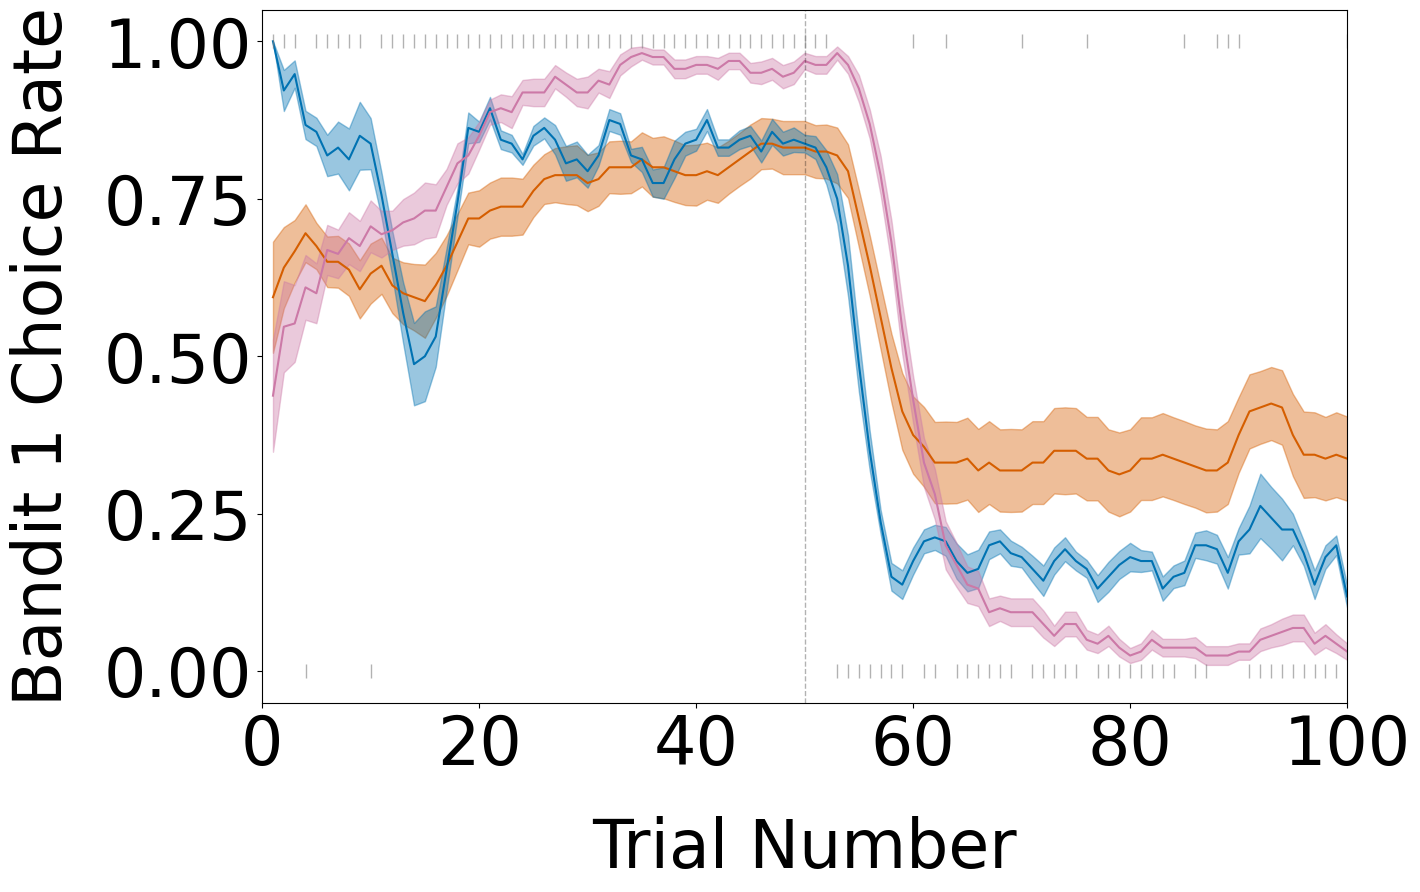

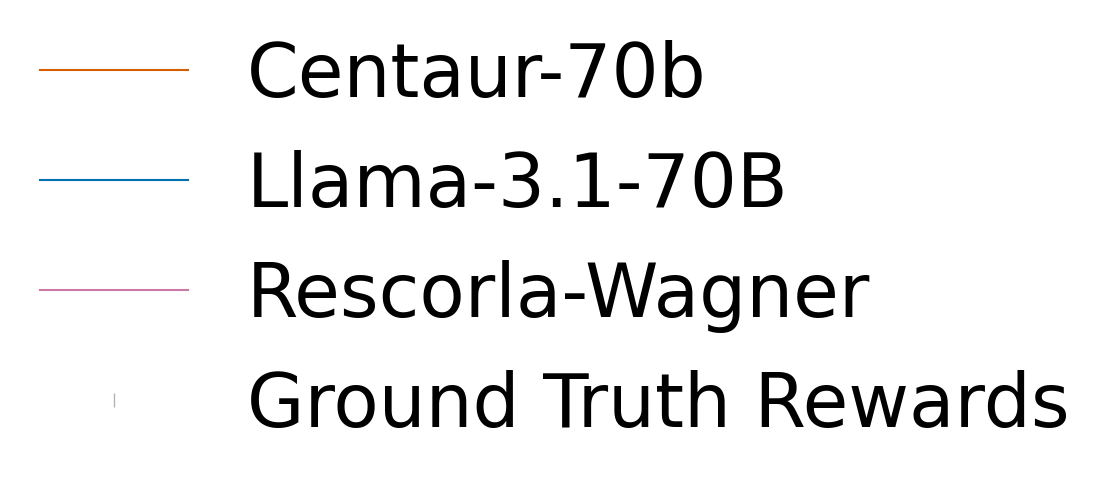

In [38]:
choice_rate_large_only,reversal_learning_legend=plot_bandit_choice_trends_single_axis(
    human_df=None,
    df_rep=None,
    dfs=[centaur_70B_df,llama_70B_df,rw_df],
    labels=['Centaur-70b','Llama-3.1-70B','Rescorla-Wagner','Repetetive'],
    timeline=timeline,
    legend_anchor=(0.4, 0.45),
    reversal_trials=[50],
    colors=colors_large_models_only
)

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap

def plot_bandit_choice_across_seeds(
    df=None, label=None, colormap='tab20b', trial_col="trial_num",
    bandit_avg_col="bandit_1_avg", reversal_trials=[14, 50],
    timeline=None, legend_anchor=(1.05, 1), xlim=(0, 100),
    title="Bandit 1 Choice Rates Across Seeds",
    margins=True, show_legend=True
):
    """
    Plots bandit 1 choice trends for each seed/model_id using perceptually distinct colors.
    """
    fig, ax_main = plt.subplots(figsize=(12, 10))
    # --- Model Data ---
    if df is not None and 'model_id' in df.columns:
        model_ids = df['model_id'].unique()
        cmap = get_cmap(colormap)
        color_shades = [cmap(i) for i in np.linspace(0, 1, len(model_ids))]

        for i, model_id in enumerate(model_ids):
            model_data = df[df['model_id'] == model_id]
            ax_main.plot(
                model_data[trial_col],
                model_data[bandit_avg_col],
                label=f'Seed {model_id}',
                color=color_shades[i],
                linestyle='-',
                linewidth=1.5,
                alpha=0.9,
                zorder=3
            )

    # --- Reversal Lines ---
    for reversal in reversal_trials:
        ax_main.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0,
                        alpha=0.3, zorder=0)

    # --- Reward Ground Truth ---
    if timeline is not None:
        bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
        ax_main.plot(
            range(1, len(bandit_1_rewards) + 1),
            bandit_1_rewards,
            color='gray',
            marker='|',
            linestyle='',
            markersize=10,
            alpha=0.6,
            label='Ground Truth Rewards'
        )

    ax_main.set_xlabel("Trial Number")
    ax_main.set_ylabel("Bandit 1 Choice Rate")
    #ax_main.set_title(title)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(-0.05, 1.05)

    if show_legend:
        ax_main.legend(loc='upper left', bbox_to_anchor=legend_anchor)

    ax_main.grid(False)
    ax_prob.axis('off')
    plt.tight_layout()
    plt.show()

    return fig

In [41]:
def plot_bandit_choice_across_selected_seeds(
    df=None, label=None, trial_col="trial_num",
    bandit_avg_col="bandit_1_avg", reversal_trials=[14, 50],
    timeline=None, legend_anchor=(1.05, 1), xlim=(0, 100),
    title="Bandit 1 Choice Rates Across Seeds",
    margins=True, show_legend=True,
    selected_model_ids=None,  # <-- New argument
            # Use 6 fixed, visually distinct colors
    color_shades = ['#1f77b4',  # blue
                        '#ff7f0e',  # orange
                        '#2ca02c',  # green
                        '#d62728',  # red
                        '#9467bd',  # purple
                        '#8c564b']  # brown

):
    """
    Plots bandit 1 choice trends for each seed/model_id using perceptually distinct colors.
    If selected_model_ids is provided, only those IDs will be plotted.
    """
    fig, ax_main = plt.subplots(figsize=(14, 10))

    # --- Model Data ---
    if df is not None and 'model_id' in df.columns:
        model_ids = df['model_id'].unique()

        if selected_model_ids is not None:
            model_ids = [mid for mid in model_ids if mid in selected_model_ids]

        color_shades = color_shades
        if len(model_ids) > len(color_shades):
            print("Warning: More than 6 models selected; colors will repeat.")


        for i, model_id in enumerate(model_ids):
                model_data = df[df['model_id'] == model_id]
                ax_main.plot(
                    model_data[trial_col],
                    model_data[bandit_avg_col],
                    label=f'Seed {model_id}',
                    color=color_shades[i % len(color_shades)],
                    linestyle='-',
                    linewidth=1.5,
                    alpha=0.9,
                    zorder=3
                )

    # --- Reversal Lines ---
    for reversal in reversal_trials:
        ax_main.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0,
                        alpha=0.3, zorder=0)

    # --- Reward Ground Truth ---
    if timeline is not None:
        bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
        ax_main.plot(
            range(1, len(bandit_1_rewards) + 1),
            bandit_1_rewards,
            color='gray',
            marker='|',
            linestyle='',
            markersize=10,
            alpha=0.6,
            label='Ground Truth Rewards'
        )

    ax_main.set_xlabel("Trial Number")
    ax_main.set_ylabel("Bandit 1 Choice Rate")
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(-0.05, 1.05)

    if show_legend:
        ax_main.legend(loc='upper left', bbox_to_anchor=legend_anchor)

    ax_main.grid(False)
    plt.tight_layout()
    plt.show()

    return fig